In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [17]:
def plotday(data, labels=None, title=None, zeroline=False, colors=['orange', 'steelblue','teal']):

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    #create pandaseries to get the correct ticks
    idx = pd.date_range('00:00', '23:59', freq='15min')
    testSeries = pd.Series(data=np.random.randn(len(idx)), index=idx)
    ticks = testSeries.index[testSeries.index.minute == 0]

    if np.ndim(data) == 1: data = [data]
    for i, d in enumerate(data):
        series = pd.Series(d, index=idx)
        if not labels: 
            graph_col = 'orange' if i == len(data)-1 else 'black'
            graph_alpha = 1 if i == len(data)-1 else 0.2
            series.plot(ax=ax, color=graph_col,alpha=graph_alpha)
        else:
            series.plot(ax=ax, label=labels[i], color=colors[i],alpha=0.6)
    
    ax.legend()
    ax.set_title(title if title else 'Daily Average consumtpion (kwH)')
    ax.set_ylabel('Consumption (kwH)')
    
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks.strftime('%H:%M'))
    n=2
    # [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
    ax.grid(True, axis='x')
    if zeroline: ax.axhline(y = 0, color = 'red')
    
    plt.show()

In [2]:
data = np.load('../../data/train/dataset_full.npz', allow_pickle=True)
data_feature = data['f'] 
data_feature = np.reshape(data_feature,(len(data_feature),len(data_feature[0])))
data_attribute = data['a'] 
data_attribute = np.array([row[0:2] for row in data_attribute])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


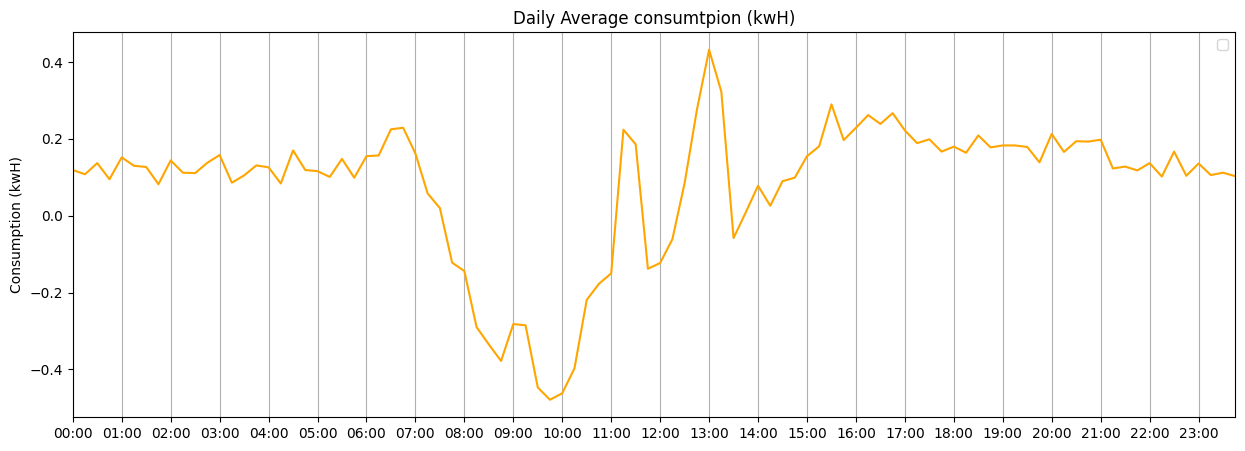

In [18]:
plotday(data_feature[-50])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


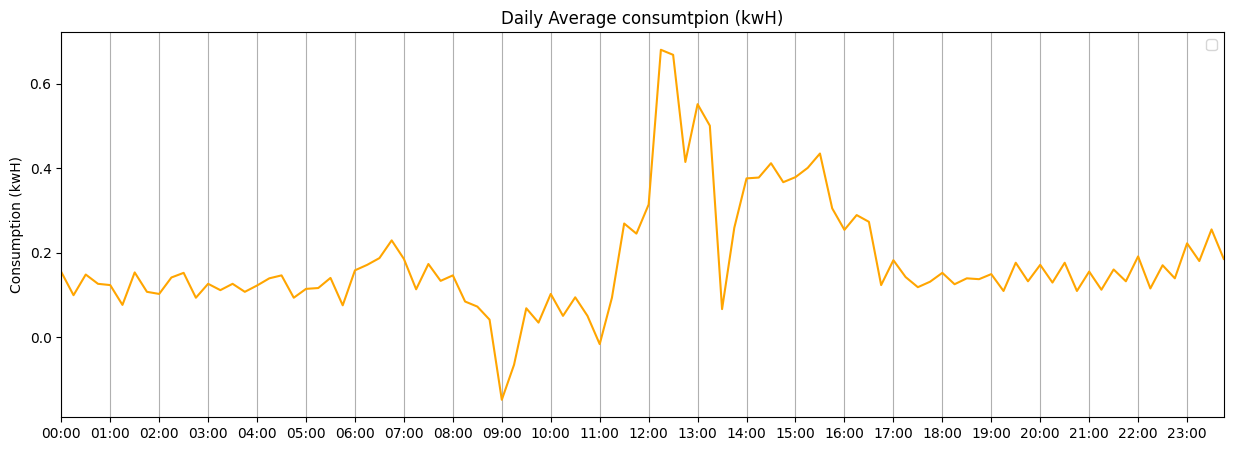

In [19]:
plotday(data_feature[-49])

In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
household1 = data_feature[-365:]
household2 = data_feature[-365*2:-365]
household3 = data_feature[-365*3:-365*2]
household4 = data_feature[:366]
household5 = data_feature[366:366*2]
household6 = data_feature[366*2:366*3]
list = [household1,household2,household3,household4,household5,household6]
dist = 0.0

for i1,h1 in enumerate(list):
    for i2,h2 in enumerate(list):
        i = 0
        for g in h1:
            for o in h2:
                distance, _ = fastdtw([g],[o],dist=euclidean)
                dist += distance
                i += 1
        dist /= i
        print(f'household{i1+1} - household{i2+1}:{dist}')
# distances = fastdtw(org, gen,dist=euclidean)
# household1 - household1:3.2083898416127528
# household1 - household2:2.671985358798224
# household1 - household3:3.3135021994521217
# household1 - household4:2.5733696830873107
# household1 - household5:3.3875132639940464
# household1 - household6:3.976245850455635
# household2 - household2:0.8133580993133364
# household2 - household3:2.1441979398584414
# household2 - household4:0.7664961490331941
# household2 - household5:1.8967005188348096
# household2 - household6:3.146786918965103
# household3 - household3:2.5040510813713923
# household3 - household4:2.0428857708067363
# household3 - household5:3.0572747945927707
# household3 - household6:3.6879966884164532
# household4 - household4:0.5444420782199874
# household4 - household5:1.7819905750767597
# household4 - household6:3.0356820919833
# household5 - household5:2.6374055499386517
# household5 - household6:3.708853947557656
# household6 - household6:3.984305356519379

In [85]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances_chunked
def calculate_energy_score(probs_for_sample, samples, correct_profile):
    """
        samples: 2d numpy array shape (#samples, #dim) , rows are predicted samples
        probs_for_sample: 1d numpy array shape (#samples), for each sample in samples the probability that it will get sampled
        correct_profile: 1d numpy array shape (#dim), the ground truth sample
    """
    def reduce_function(chunk, start):
        sums = (chunk * probs_for_sample).sum(axis = 1)
        return sums*probs_for_sample[start:start + sums.shape[0]]

    # because the full distance array gets very very large (GB's), process the chunks seperately into the needed sum
    second_term = 0
    for chunk in pairwise_distances_chunked(samples, reduce_func = reduce_function):
        second_term += chunk.sum(axis = None)
    distances_between_test_and_training_days = euclidean_distances(samples, correct_profile.reshape((1, -1))).squeeze()
    
    first_term = np.sum(probs_for_sample * distances_between_test_and_training_days)

    return first_term - 0.5*second_term

In [103]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
household1 = data_feature[-365:]
household2 = data_feature[-365*2:-365]
household3 = data_feature[-365*3:-365*2]
household4 = data_feature[:366]
household5 = data_feature[366:366*2]
household6 = data_feature[366*2:366*3]
list = [household1,household2,household3,household4,household5,household6]
dist = 0.0
for i1,h1 in enumerate(list):
    for i2,h2 in enumerate(list):
        household1_avg = h2.mean(axis=0)
        score = calculate_energy_score([1/len(h1)]*len(h1), h1, household1_avg)
        print(f'household{i1+1} - household{i2+1}:{score}')

household1 - household1:0.6866051077804993
household1 - household2:0.9875188858164807
household1 - household3:1.1552618817221556
household1 - household4:0.9334504330217728
household1 - household5:0.9553690126534571
household1 - household6:1.1993208264135982
household2 - household1:0.9463375603853972
household2 - household2:0.1439550557082933
household2 - household3:0.8661792450158883
household2 - household4:0.2393582852102512
household2 - household5:0.845352082116533
household2 - household6:1.5622058379694046
household3 - household1:1.0799927543098842
household3 - household2:0.7772177926992843
household3 - household3:0.5109081851518356
household3 - household4:0.743499008355688
household3 - household5:1.079053185419855
household3 - household6:1.295414416050042
household4 - household1:0.9055044749708233
household4 - household2:0.22741566119343692
household4 - household3:0.8435252053399694
household4 - household4:0.10384073826758766
household4 - household5:0.9051920648869366
household4 - 

In [69]:
dist

2.6719612763074

In [64]:
dist

3.313482143266279

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


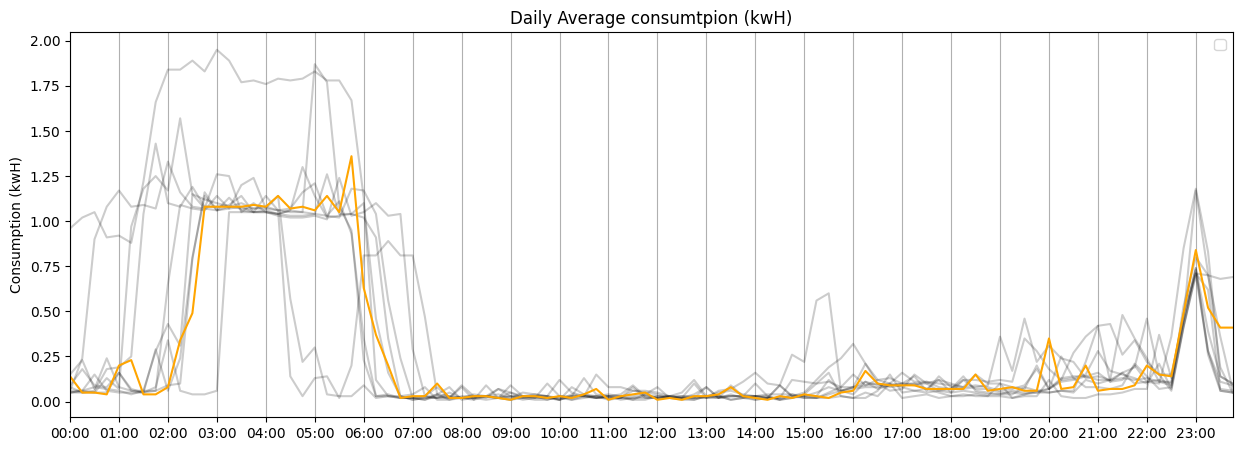

In [106]:
plotday(household6[0:10])

In [ ]:
data_attribute

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


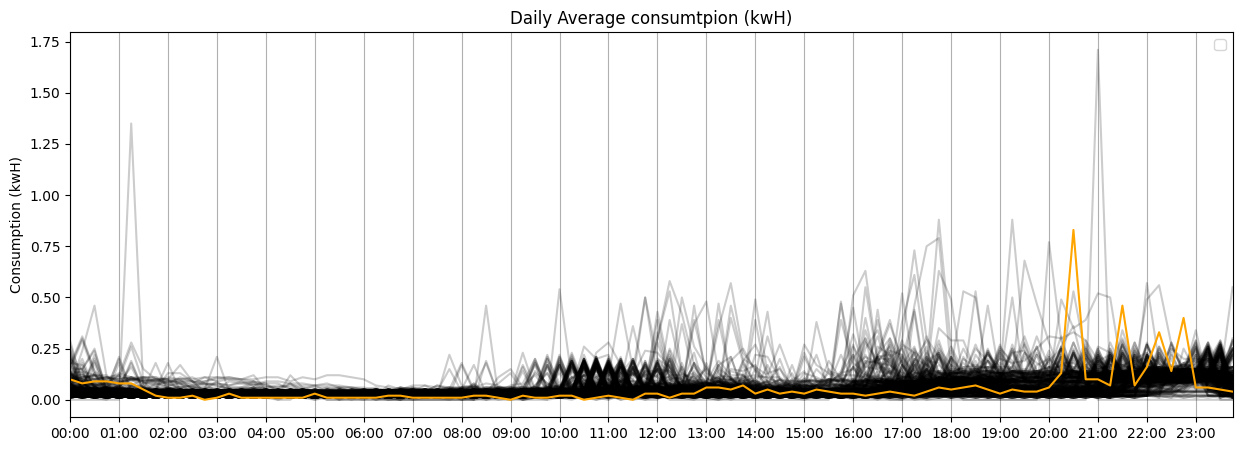

In [77]:
plotday(household4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


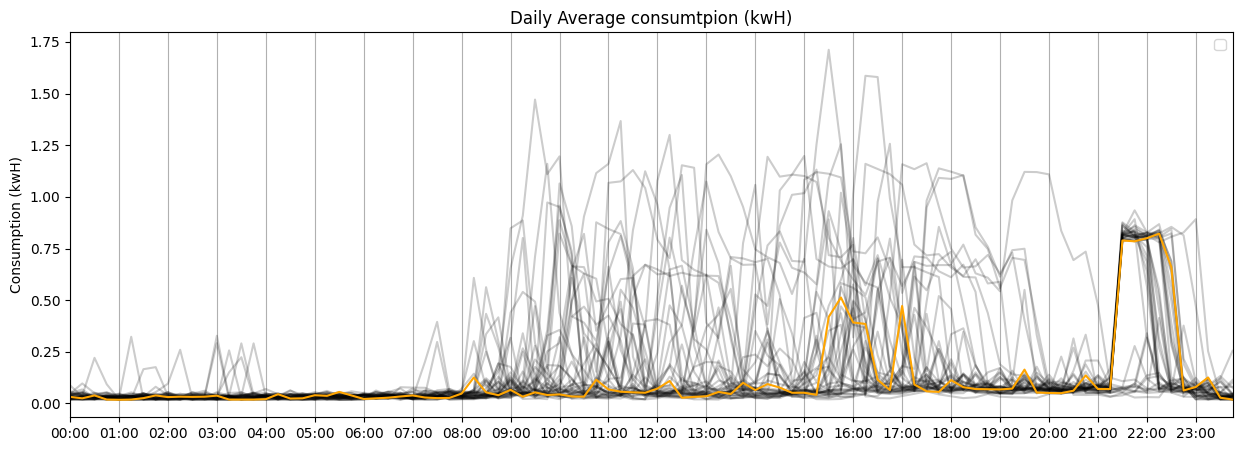

In [105]:
plotday(household3[0:40])